# Evaluation notebook

Copyright 2024 Universitat Politècnica de Catalunya

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
import os

# It is recommended to run this script on CPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pickle import load

from data.data_loader import load_partition
import models

2024-07-09 17:57:50.428807: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 17:57:50.428846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 17:57:50.429541: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-09 17:57:50.434286: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-09 17:57:50.951010: W tensorflow/compiler/tf2

### Step 1: prepare the test dataset

For the combined dataset, we extract the MAWI samples in the test partition.

For the split dataset, we use all the MAWI samples available (as none were used for
training or validation).

In [2]:
def filter_only_mawi(x, y):
    return tf.math.reduce_all(tf.math.equal(x["flow_time_dist"], 2))

# This function is used to get the size of a dataset after .filter is applied
def get_ds_size_alt(ds):
    return sum(1 for _ in ds)


combined_test_ds = load_partition("data/combined_ds/test").prefetch(
    tf.data.experimental.AUTOTUNE
)
print(len(combined_test_ds))
combined_test_ds = combined_test_ds.filter(filter_only_mawi)
print(get_ds_size_alt(combined_test_ds))

split_test_ds = load_partition("data/split_ds/test").prefetch(
    tf.data.experimental.AUTOTUNE
)
print(len(split_test_ds))

2024-07-09 17:57:55.161285: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-07-09 17:57:55.161316: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: saturn
2024-07-09 17:57:55.161320: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: saturn
2024-07-09 17:57:55.161414: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.146.2
2024-07-09 17:57:55.161429: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.146.2
2024-07-09 17:57:55.161431: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.146.2


1218
393
4046


# Step 2: Load models with checkpoint

In [3]:
def get_prepared_model(model_class, model_parms, model_checkpoint):
    """Returns a model with the given parameters and checkpoint.

    Parameters
    ----------
    model_class : tf.keras.Model
        Model Class
    model_parms : dict
        Dict containing the necessary parameters for the model
    model_checkpoint : str
        Path to checkpoint to be restored. The checkpoint is loaded using
        tf.keras.Model.load_weights
    """
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
    loss = tf.keras.losses.MeanAbsolutePercentageError()
    model = model_class(**model_parms)
    model.compile(optimizer=optimizer, loss=loss)
    model.load_weights(model_checkpoint).expect_partial()
    return model

In [4]:
# Paper models: feel free to modify/ add yor own!
with open("data/fermi_normalization/original/combined_ds/z_scores.pkl", "rb") as ff:
    parameter_model_z_scores = load(ff)

parameter_model_w_mawi = get_prepared_model(
    models.RouteNet_Fermi,
    {
        "z_scores": parameter_model_z_scores,
        "max_num_dist": 3,
    },
    "ckpt/paper_ckpts/combined_ds/RouteNet_Fermi",
)
single_level_wlt_model_w_mawi = get_prepared_model(
    models.RouteNet_Fermi_wavelet_single_level,
    {"wt_field": "coif2_cA10"},
    "ckpt/paper_ckpts/combined_ds/RouteNet_Fermi_wavelet_single_level",
)
multi_level_wlt_model_w_mawi = get_prepared_model(
    models.RouteNet_Fermi_wavelet_multiple_level,
    {"wt_fields": ["db1_cD4", "db1_cD6", "db1_cD8", "db1_cD10", "db1_cA10"]},
    "ckpt/paper_ckpts/combined_ds/RouteNet_Fermi_wavelet_multiple_level",
)


with open("data/fermi_normalization/original/split_ds/z_scores.pkl", "rb") as ff:
    parameter_model_z_scores = load(ff)
   
parameter_model_wo_mawi = get_prepared_model(
    models.RouteNet_Fermi,
    {
        "z_scores": parameter_model_z_scores,
        "max_num_dist": 2,
    },
    "ckpt/paper_ckpts/split_ds/RouteNet_Fermi",
)
single_level_wlt_model_wo_mawi = get_prepared_model(
    models.RouteNet_Fermi_wavelet_single_level,
    {"wt_field": "coif2_cA10"},
    "ckpt/paper_ckpts/split_ds/RouteNet_Fermi_wavelet_single_level",
)
multi_level_wlt_model_wo_mawi = get_prepared_model(
    models.RouteNet_Fermi_wavelet_multiple_level,
    {"wt_fields": ["db1_cD4", "db1_cD6", "db1_cD8", "db1_cD10", "db1_cA10"]},
    "ckpt/paper_ckpts/split_ds/RouteNet_Fermi_wavelet_multiple_level",
)

Step 3: Perform the evaluations

In [5]:
combined_scores = [
    parameter_model_w_mawi.evaluate(combined_test_ds),
    single_level_wlt_model_w_mawi.evaluate(combined_test_ds),
    multi_level_wlt_model_w_mawi.evaluate(combined_test_ds),
]

split_scores = [
    parameter_model_wo_mawi.evaluate(split_test_ds),
    single_level_wlt_model_wo_mawi.evaluate(split_test_ds),
    multi_level_wlt_model_wo_mawi.evaluate(split_test_ds),
]

4046/4046 [==============================] - 3282s 810ms/step - loss: 20.9561


Step 4: Plot the results

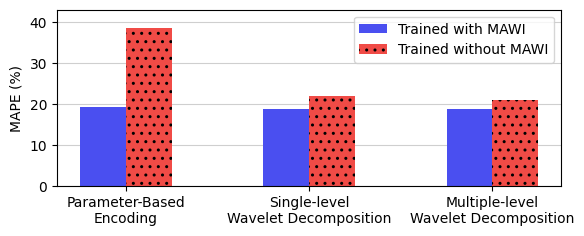

In [6]:
variants = [
    "Parameter-Based\nEncoding",
    "Single-level\nWavelet Decomposition",
    "Multiple-level\nWavelet Decomposition",
]
data = {
    "Trained with MAWI": combined_scores,
    "Trained without MAWI": split_scores,
}
hatches = ["", ".."]
colors = ["#4A4FF0", "#F04B46"]
width = 0.25
x = np.arange(len(variants))

fig, ax = plt.subplots(figsize=(6, 2.5))

for ii, (experiment, vals) in enumerate(data.items()):
    ax.bar(
        x + (width * (ii + 0.5)),
        vals,
        width,
        label=experiment,
        hatch=hatches[ii],
        color=colors[ii],
        edgecolor="black",
        linewidth=0,
    )

ax.set_ylabel("MAPE (%)")
ax.set_xticks(x + width, variants)
ax.legend()
fig.tight_layout()
ax.set_ylim(0, 43)
ax.set_axisbelow(True)
ax.grid(axis="y", alpha=0.6)

plt.show(block=True)
plt.close(fig)